In [1]:
#!/Users/jbm/miniforge3/envs/dedalus3/bin/python3
"""
Shallow Water Equations EVP 

February 2026
Authors: Leopold Li, Brad Marston

---------------------------------------------------------------------------
    This script solves the EVP for the shallow water equations with a 
    chosen coriolis parameter and computes and plots a spectrum

        ∂ₜu + ∂ₓh - fv = 0
        ∂ₜv + ∂ᵧh + fu = 0
        ∂ₜh + ∂ₓu + ∂ᵧv = 0

    Double-tanh plane: 
        f = tanh(⍺(y-y₀)) - tanh(⍺(y+y₀)) + 1
    β-plane: 
        f = f₀ + βy
    sin-equator:
        f = sin(y)
---------------------------------------------------------------------------
"""

path = '[your path]'

import time
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

import dedalus.public as d3
from mpi4py import MPI
CW = MPI.COMM_WORLD
import logging
logger = logging.getLogger(__name__)
import matplotlib


In [2]:
"""
Domain Parameters
"""

Nx = 64 
Ny = 128
Ly = 20*np.pi
Lx = 10
y0 = Ly/4

alpha = 1.2 # Double-tanh sharpness
f0 = 1 #Beta plane f₀
kmax = np.pi # horizontal wave number extrema
kx_global = np.linspace(-kmax,kmax,100) # Array of wavenumbers

ky = 0.0
N = 1

def problem_builder(kx):
    # Create bases and domain
    ycoord = d3.Coordinate('y')
    dist = d3.Distributor(ycoord, dtype=np.complex128)
    ybasis = d3.ComplexFourier(ycoord, size=Ny, bounds=(-Ly/2, Ly/2))
    y = dist.local_grids(ybasis) # grid

    # Fields 
    u = dist.Field(name='u', bases=ybasis)
    v = dist.Field(name='v', bases=ybasis)
    h = dist.Field(name='h', bases=ybasis)
    omega = dist.Field(name='omega')

    # Substitution 
    dy = lambda A: d3.Differentiate(A, ycoord)
    dx = lambda A: 1j*kx*A
    dt = lambda A: -1j*omega*A
    ky = 1

    # define non-constant coefficients
    f = dist.Field(bases=ybasis)
    # f['g'] = f0*np.sin(2*np.pi*y[0]/Ly) # sin coriolis parameter  
    f['g'] = f0*(np.tanh(alpha*(y[0]-y0)) -np.tanh(alpha*(y[0]+y0)) +1) # double tanh equator

    problem = d3.EVP([u, v, h], eigenvalue=omega, namespace=locals())

    problem.add_equation("dt(u) + dx(h) - f * v = 0")
    problem.add_equation("dt(v) + dy(h) + f * u = 0")
    problem.add_equation("dt(h) + dx(u) + dy(v) = 0")

    solver = problem.build_solver()
    return solver, ybasis, dist


In [3]:
# Compute horizontal wavenumber k_x
def make_array_omega(kx):
    logger.info('Computing array of omega values at kx = %f' %kx)
    # Change kx parameter
    solver, ybasis, dist = problem_builder(kx)
    solver.solve_dense(solver.subproblems[0])
    evals = np.sort(solver.eigenvalues)
   
    return evals

# Compute spectrum
omega = np.array([make_array_omega(kx) for kx in kx_global])


2026-02-23 13:46:26,410 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.141593
2026-02-23 13:46:26,482 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2026-02-23 13:46:26,897 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.078126
2026-02-23 13:46:26,929 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+01/s
2026-02-23 13:46:27,345 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.014660
2026-02-23 13:46:27,377 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2026-02-23 13:46:27,791 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.951193
2026-02-23 13:46:27,822 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s
2026-02-23 13:46:28,236 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.8877

In [4]:
# Compute localization
def make_loc(kx):
    logger.info('Computing array of omega values at kx = %f' %kx)
    # Change kx parameter
    solver, ybasis, dist = problem_builder(kx)
    # y = dist.local_grids(ybasis)[0] 
    solver.solve_dense(solver.subproblems[0])
    
    order = np.argsort(solver.eigenvalues.real)
    evals = np.sort(solver.eigenvalues)
    solver.eigenvalues = evals
    solver.eigenvectors = solver.eigenvectors[:, order]
    

    loc=np.zeros(order.size)
    for iorder in np.arange(order.size):
        solver.set_state(iorder,solver.subsystems[0])
        umode = solver.state[0]['g'] # find the first field 
        norm = umode * umode.conjugate()
        normf = dist.Field(name='normf', bases=ybasis)
        normf['g'] = norm.real
        
        normy = np.sin(2*np.pi*dist.local_grids(ybasis)[0]/Ly) * norm  # PBCs
       
        normyf = dist.Field(name='normyf', bases=ybasis)
        normyf['g'] = normy.real
        loc[iorder]= d3.Integrate(normyf).evaluate()['g'][0].real/d3.Integrate(normf).evaluate()['g'][0].real
    
    return loc

loc_real = np.array([make_loc(kx) for kx in kx_global])
kx_real =np.array([kx*np.ones(omega.shape[1]) for kx in kx_global])


2026-02-23 13:47:11,491 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.141593
2026-02-23 13:47:11,530 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2026-02-23 13:47:12,034 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.078126
2026-02-23 13:47:12,068 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.3e+01/s
2026-02-23 13:47:12,558 __main__ 0/1 INFO :: Computing array of omega values at kx = -3.014660
2026-02-23 13:47:12,591 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+01/s
2026-02-23 13:47:13,084 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.951193
2026-02-23 13:47:13,122 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+01/s
2026-02-23 13:47:13,640 __main__ 0/1 INFO :: Computing array of omega values at kx = -2.8877

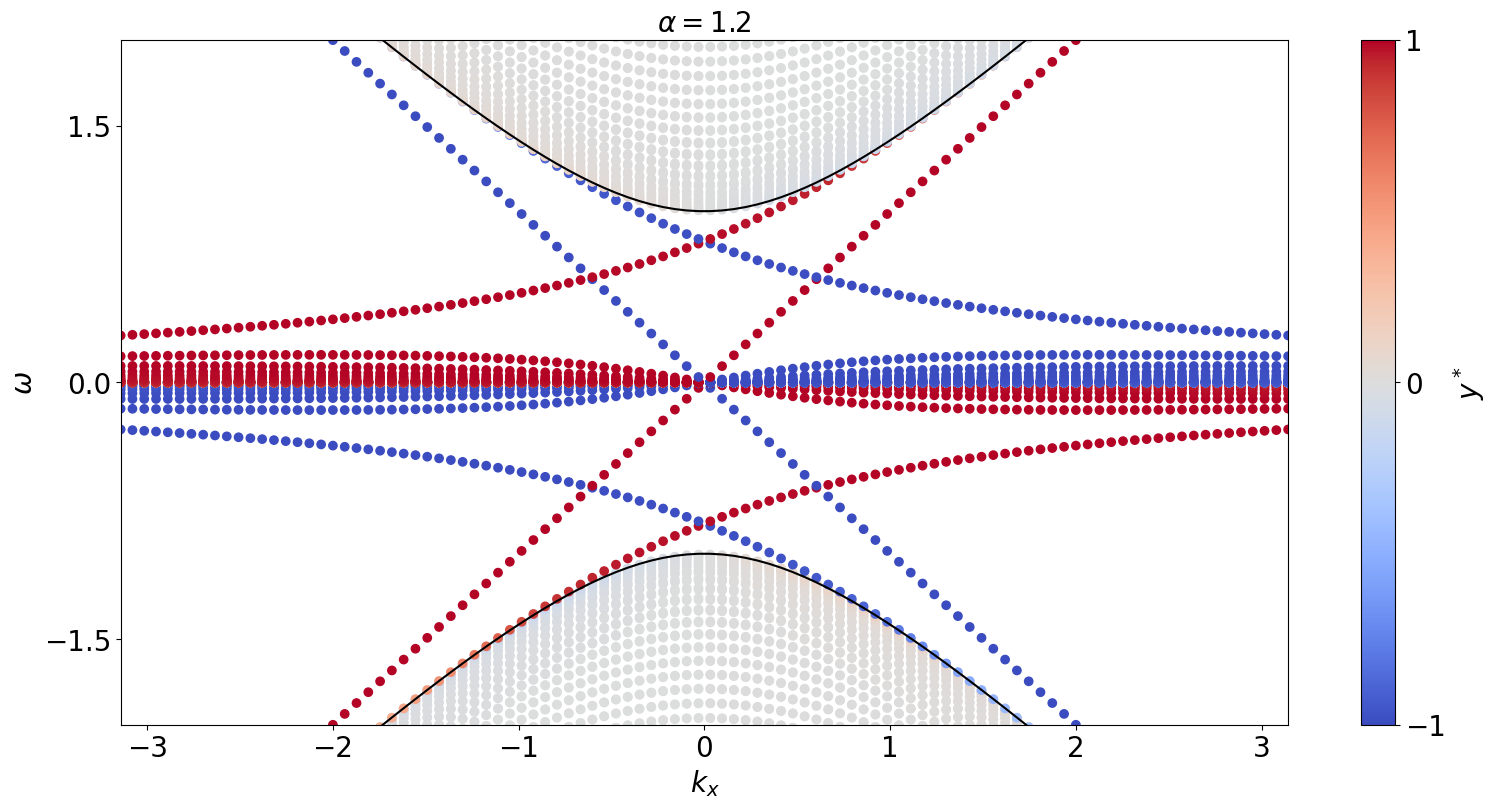

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [5]:
# plot the spectrum 
fig, ax = plt.subplots(figsize=(16, 8))

ylim = np.array([-1., 1.])*2
plt.ylim(ylim)


# Plot the analytical shallow water spectrum for f = 1
kx=kx_global
om = ( kx**2 + 1)**0.5
im = ax.plot(kx_global,om,color='black')
im = ax.plot(kx_global,-om,color='black')
plt.xlabel('$k_x$')
plt.ylabel('$\\omega$') 
    
# plot the real part of the spectrum
im = ax.scatter(kx_real, omega.real, c=loc_real, cmap=plt.cm.coolwarm, vmin=-1, vmax=1)
cbar=fig.colorbar(im, ax=ax, ticks=[-1.0,0.0,1.0])
cbar.ax.tick_params(labelsize=20)
cbar.set_label('$y^*$', size=20)

ax.set_xticks([-3, -2, -1, 0, 1, 2, 3,])
ax.set_yticks([ -1.5, 0, 1.5])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
    plt.tight_layout()

plt.xlim([np.min(kx_global), np.max(kx_global)])
plt.title(f'$\\alpha = ${alpha}', fontsize = 20)
plt.show()
plt.save(path + 'swe_spectrum.png',  bbox_inches='tight')
